In [1]:
! pip install pandas matplotlib networkx

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
import pandas as pd

# Load data from the API
url = "https://sheetdb.io/api/v1/3digbv94ticxe"
df = pd.read_json(url)

# Save the raw data to CSV
df.to_csv("raw_dataset.csv", index=False)
print("Raw dataset saved as raw_dataset.csv")


Raw dataset saved as raw_dataset.csv


In [16]:
df.head()

,id,first_name,last_name,email,gender,amount,timestramp,location,is_fraud,device_used,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,transaction_type,merchant_category
0,1,Romonda,Roycroft,rroycroft0@jalbum.net,Female,$434.43,6:37 PM,KS,False,mobile,-0.21,3,0.22,card,13.101.214.112,D8536477,withdrawal,utilities
1,2,Annaliese,Trethowan,atrethowan1@squidoo.com,Female,$710.54,3:46 AM,IL,False,atm,-0.14,7,0.96,ACH,172.52.47.194,D2622631,withdrawal,online
2,3,Marion,Hartropp,mhartropp2@hexun.com,Male,$502.79,3:21 PM,OH,False,pos,-1.78,20,0.89,card,185.98.35.23,D4823498,deposit,other
3,4,Dmitri,Woollard,dwoollard3@myspace.com,Male,$776.08,5:54 PM,ME,False,pos,-0.6,6,0.37,wire_transfer,107.136.36.87,D9961380,deposit,online
4,5,Claire,Ilbert,cilbert4@people.com.cn,Female,$463.30,1:07 PM,ME,True,mobile,0.79,13,0.27,ACH,108.161.108.255,D7637601,transfer,utilities


In [20]:
# 2. Standardize fraud column to boolean
df['is_fraud'] = df['is_fraud'].astype(str).str.strip().str.upper().isin(["TRUE", "1", "YES"])
df['is_fraud'].value_counts()


,count
is_fraud,
False,5098
True,4902


In [6]:
# 3. Create the graph
G = nx.Graph()

In [7]:
G

In [8]:
#Tuning
for _, row in df.iterrows():
    user = f"user_{row['id']}"
    device = f"device_{row['device_hash']}"
    ip = f"ip_{row['ip_address']}"
    merchant = f"merchant_{row['merchant_category']}"
    location = f"loc_{row['location']}"

In [9]:
G.add_node(user)

In [10]:

    # Add edges if data is available
    if pd.notna(row['device_hash']):
        G.add_edge(user, device)
    if pd.notna(row['ip_address']):
        G.add_edge(user, ip)
    if pd.notna(row['merchant_category']):
        G.add_edge(user, merchant)
    if pd.notna(row['location']):
        G.add_edge(user, location)

In [11]:
# 4. Get fraud users
fraud_users = {f"user_{uid}" for uid in df.loc[df['is_fraud'], 'id']}

In [12]:

# 5. Get fraud subgraph (fraud users + their neighbors)
fraud_nodes = set(fraud_users)
for u in fraud_users:
    if u in G:
        fraud_nodes.update(G.neighbors(u))

fraud_subgraph = G.subgraph(fraud_nodes)


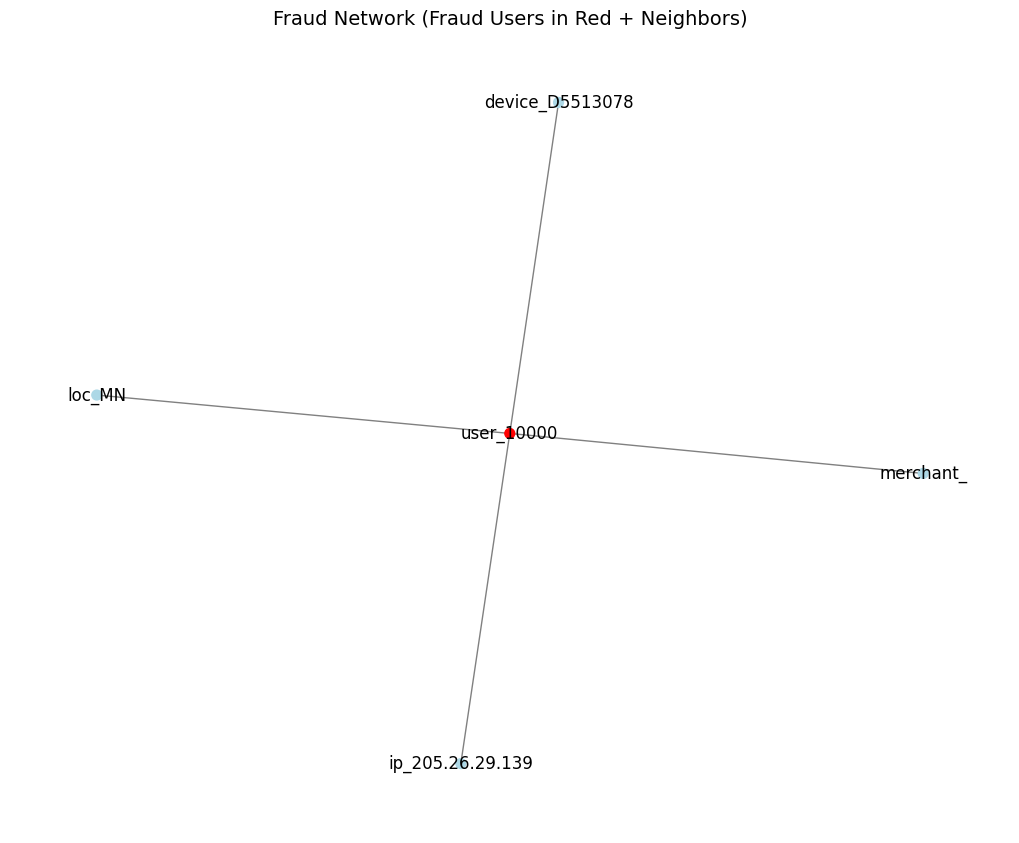

In [13]:
# 6. Plot fraud subgraph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(fraud_subgraph, seed=100, k=0.3)
node_colors = ["red" if n in fraud_users else "lightblue" for n in fraud_subgraph.nodes()]
nx.draw(fraud_subgraph, pos, node_size=50, with_labels=True, edge_color="gray", node_color=node_colors)
plt.title("Fraud Network (Fraud Users in Red + Neighbors)", fontsize=14)
plt.show()